# Electricity Demand Forecasting

## <table id='Table_Of_Contents'>Table Of Contents</table>

1. [Import Modules](#import)<br>
2. [Read Data File](#read_data)<br>
    1. [Clean Data Frame](#clean_data)<br>
    2. [Data Split](#data_split)<br>




### <a id='import'> 1. Import Modules</a>

In [1]:
import pandas as pd
import numpy as np
import re

import json
import datetime


from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler

#from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

import pickle
import warnings

from dateutil import parser

import matplotlib.pyplot as plt

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.statespace.mlemodel

### 2. Data Import <a id='read_data'></a>

In [2]:
data_file = '../data/big_demand_temp_train.csv'

In [48]:
full_df = pd.read_csv(data_file, index_col=0)
full_df.index = pd.DatetimeIndex(full_df.index)

In [49]:
full_df.head()

,demand,Los Angeles,San Diego,San Jose,San Francisco,Sacramento,Fresno,CA_pop,Mon,Tue,Wed,Thur,Fri,Sat,Sun,DOW
2015-07-01 08:00:00+00:00,38210,71.60,68.76,70.89,59.32,79.80,86.04,13845790.0,0,0,1,0,0,0,0,2
2015-07-01 09:00:00+00:00,35171,70.93,68.19,69.78,58.96,77.77,86.35,13845790.0,0,0,1,0,0,0,0,2
2015-07-01 10:00:00+00:00,33243,70.43,68.29,68.07,58.63,76.51,82.74,13845790.0,0,0,1,0,0,0,0,2
2015-07-01 11:00:00+00:00,31955,70.87,68.32,66.92,58.11,74.94,82.04,13845790.0,0,0,1,0,0,0,0,2
2015-07-01 12:00:00+00:00,31199,71.58,68.46,66.16,57.90,73.80,80.37,13845790.0,0,0,1,0,0,0,0,2


#### 2.C Data Split <a id='data_split'></a>

In [50]:
train_len = int(0.7 * full_df.shape[0])
window_len = int(0.1 * full_df.shape[0])

In [51]:
# Make the primary train/validation split
X_train = full_df.iloc[:train_len, :]

# Make intermediate trail windows for walk forward validation
X_walk1 = full_df.iloc[train_len:train_len+window_len, :]
X_walk2 = full_df.iloc[train_len+window_len:train_len+2*window_len, :]
X_walk3 = full_df.iloc[train_len+2*window_len:train_len+3*window_len, :]

In [52]:
# Look at the dataframe contents
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23006 entries, 2015-07-01 08:00:00+00:00 to 2018-02-13 21:00:00+00:00
Data columns (total 16 columns):
demand           23006 non-null int64
Los Angeles      23006 non-null float64
San Diego        23006 non-null float64
San Jose         23006 non-null float64
San Francisco    23006 non-null float64
Sacramento       23006 non-null float64
Fresno           23006 non-null float64
CA_pop           23006 non-null float64
Mon              23006 non-null int64
Tue              23006 non-null int64
Wed              23006 non-null int64
Thur             23006 non-null int64
Fri              23006 non-null int64
Sat              23006 non-null int64
Sun              23006 non-null int64
DOW              23006 non-null int64
dtypes: float64(7), int64(9)
memory usage: 3.0 MB


### 3. Helper Functions <a id='helper'></a>

In [53]:
# This funtion tests the stationarity of the data set
#   The function was originally published as part of the Blog post
#
#   https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba
#
#
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

### 4. Data Analysis <a id='analysis'></a>

#### 4.1 Stationarity Testing <a id='stationarity'></a>

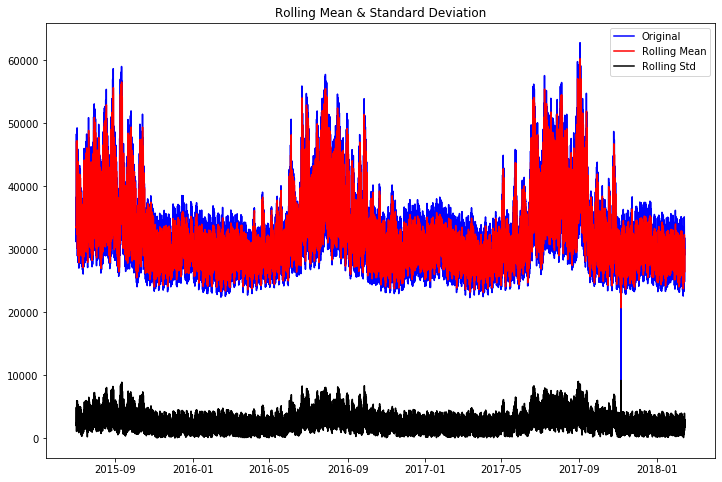

Results of Dickey-Fuller Test:
p-value = 0.0002. The series is likely stationary.
Test Statistic                    -4.499275
p-value                            0.000197
#Lags Used                        20.000000
Number of Observations Used    22985.000000
Critical Value (1%)               -3.430635
Critical Value (5%)               -2.861666
Critical Value (10%)              -2.566837
dtype: float64


In [54]:
test_stationarity(X_train.demand, window=8)

#### 4.2 Autocorrelation <a id='autocorr'></a>

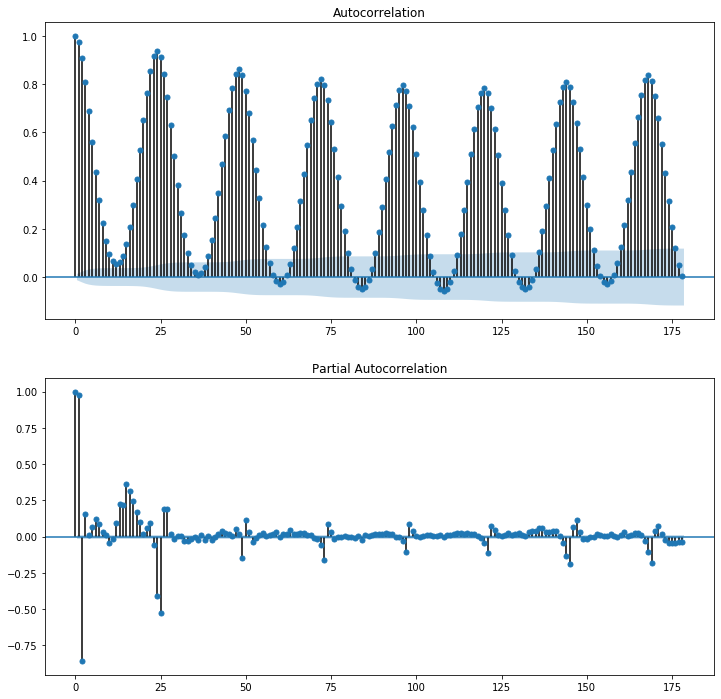

In [55]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X_train['demand'], lags=24*7+10, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(X_train['demand'], lags=24*7+10, ax=ax2)# , lags=40

#### 4.3 Seasonal Decomposition <a id='seasonal_decomp'></a>

In [56]:
# Do seasonal decopostion on the weekly periodic features
decomp_data = seasonal_decompose(X_train.demand.values[:10000], period=24, model='additive')

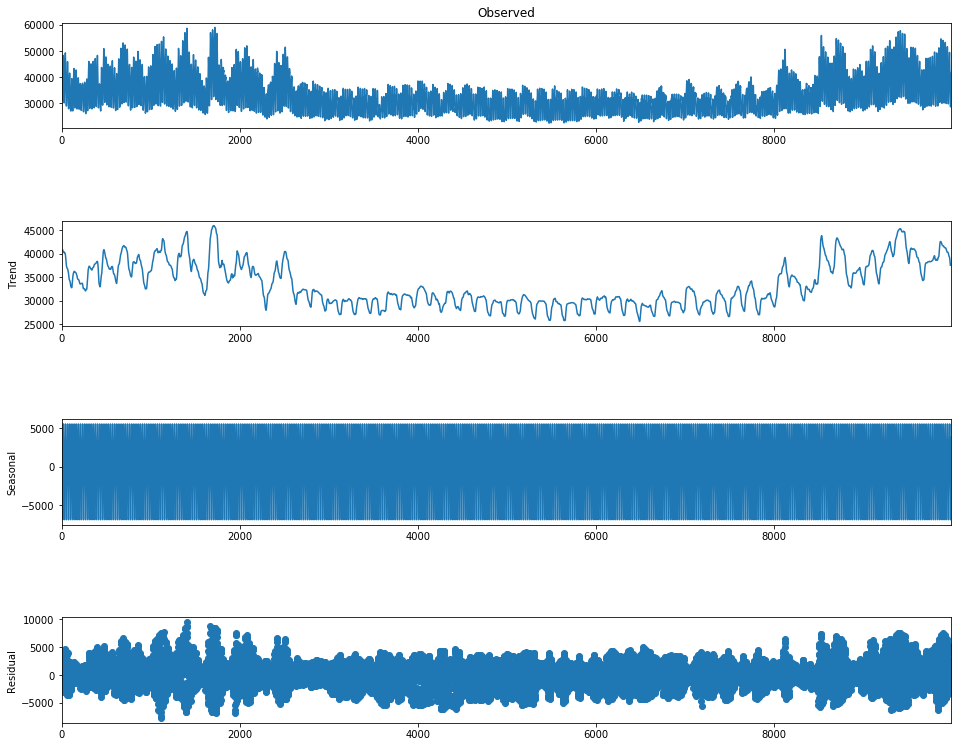

In [57]:
fig = decomp_data.plot()
fig.set_size_inches(15, 12)

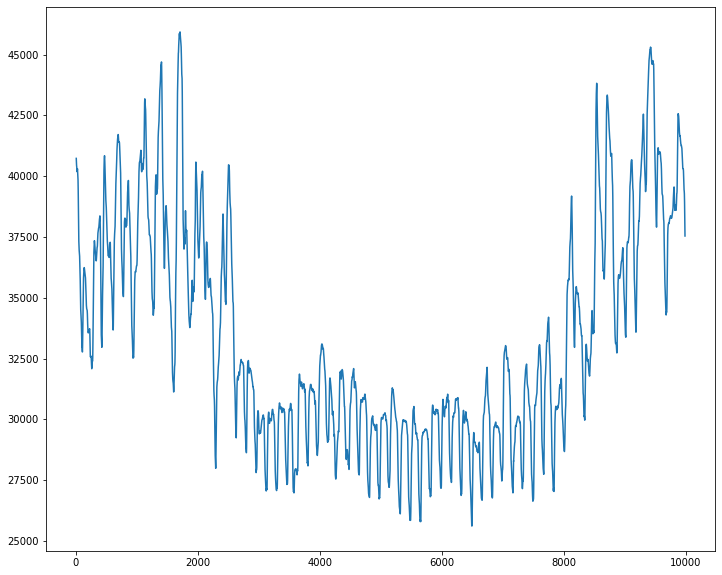

In [58]:
# Plot a closeup of the seasonal component
fig = plt.figure(figsize=[12,10])
plt.plot(decomp_data.trend[:10000])

#### 4.4 Trend Autocorrelation <a id='trend_auto'></a>

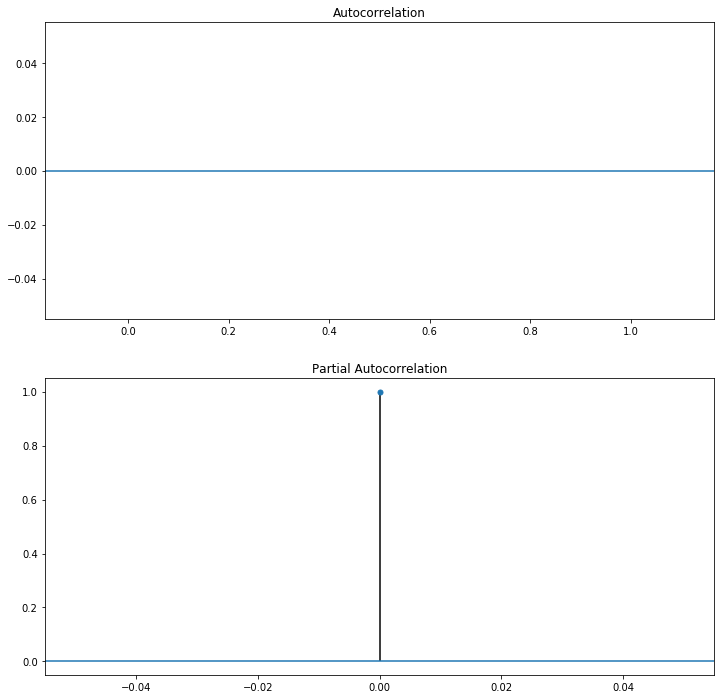

In [59]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(decomp_data.trend, lags=24*7+10, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(decomp_data.trend, lags=24*7+10, ax=ax2)

### 5. Modeling <a id='modeling'></a>

#### 5.1 SARIMAX Without Exogeneous Data <a id='SARI_NoX'></a>

In [60]:
# Define the model for SARIMAX just using the demand data
seasonal_model1 = SARIMAX(X_train['demand'], simple_differencing=True, \
    order=(4, 0, 3), seasonal_order=(2,0,0,24))

res1 = seasonal_model1.fit()

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.



In [61]:
print(res1.summary())

                                      SARIMAX Results                                      
Dep. Variable:                              demand   No. Observations:                23006
Model:             SARIMAX(4, 0, 3)x(2, 0, [], 24)   Log Likelihood             -173740.350
Date:                             Sun, 22 Mar 2020   AIC                         347500.700
Time:                                     11:23:43   BIC                         347581.136
Sample:                                 07-01-2015   HQIC                        347526.839
                                      - 02-13-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6704      0.001   1962.568      0.000       1.669       1.672
ar.L2          0.3115      

In [62]:
# Save the trained model
filename = 'SARIMAX_wo_exog.sav'
pickle.dump(seasonal_model1, open(filename, 'wb'))

In [63]:
demand_hat = res1.fittedvalues

##### 5.1.1 SARIMAX Without Exogeneous Data - Fit Plot Close <a id='plot-SARI_fit_zoom'></a>

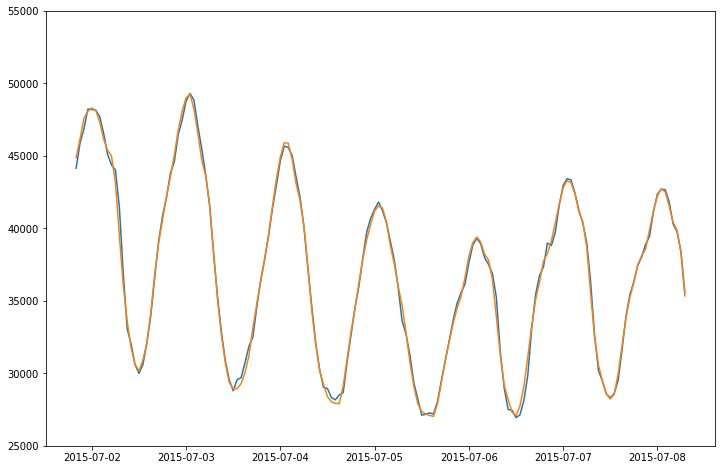

In [64]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(25000, 55000)

plt.plot(demand_hat[12:168])
plt.plot(X_train.index[12:168], X_train['demand'].values[12:168])

##### 5.1.2 SARIMAX Without Exogeneous Data - Fit Plot 3 Months  <a id='plot-SARI_fit_wide'></a>

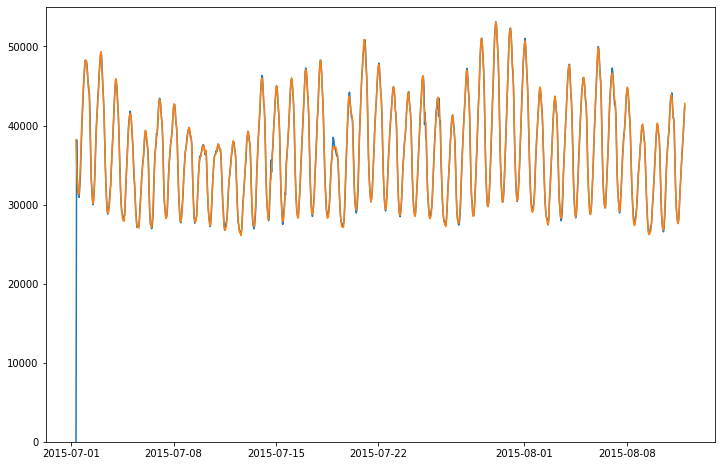

In [65]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 55000)

plt.plot(demand_hat[:1000])
actual = X_train['demand'].values[12:1012]
plt.plot(X_train.index[0:1000], X_train['demand'].values[0:1000])

----
----

##### 5.1.3 SARIMAX Without Exogeneous Data - Forecast <a id='forecast-SARI_nox'></a>

----

In [66]:
predict_steps = 168*3
predict1 = res1.get_forecast(predict_steps)
pred_ci1 = predict1.conf_int(alpha=0.5)
pred_vals1 = predict1.predicted_mean

No handles with labels found to put in legend.


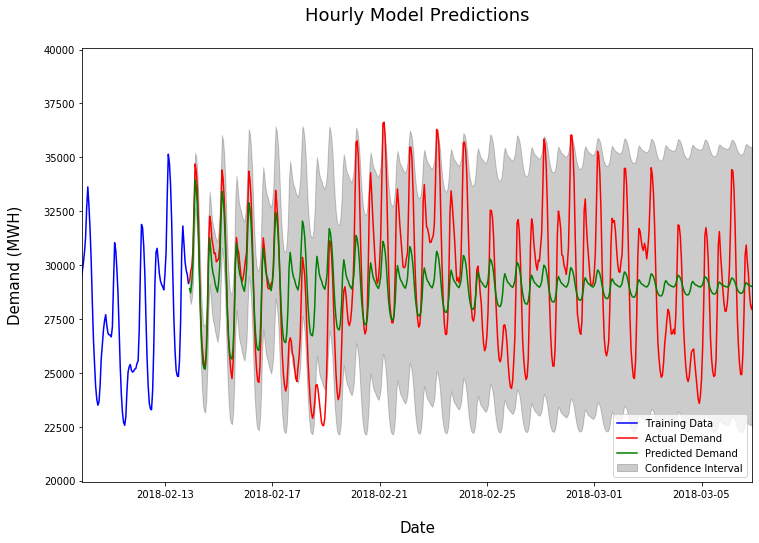

In [67]:
fig = plt.figure(figsize=[12, 8])
fig.patch.set_alpha(0.0)
fig.patch.set_facecolor(None)

ax = fig.add_subplot(1,1,1)
ax.patch.set_visible(False)
ax.set_alpha(0.0)

plt.plot(facecolor=('#000000'), alpha=0.0)

date_list = X_train.index

low_values = pred_ci1.iloc[:, 0].values
high_values = pred_ci1.iloc[:, 1].values
pred_times1 = pred_ci1.index

plt.title('Hourly Model Predictions\n', fontsize=18)
plt.xlabel('\nDate', fontsize=15)
plt.ylabel('Demand (MWH)\n', fontsize=15)
plt.legend(loc='lower right')


plt.xlim(min(date_list[int(len(date_list) - 24*4) :]), max(pred_times1))
plt.ylim(0.9*min(low_values), 1.1*max(high_values))


#plt.plot(demand_hat[:1000])
p1 = plt.plot(X_train.index, X_train['demand'].values, c='b', label='Training Data')
p2 = plt.plot(X_walk1.index, X_walk1['demand'].values, c='r', label='Actual Demand')
p3 = plt.plot(pred_times1, pred_vals1.values, c='g', label='Predicted Demand')


p4 = plt.fill_between(pred_times1, low_values, high_values, color='k', alpha=0.2, label='Confidence Interval')

plt.legend( loc='lower right')

plt.savefig('daily_pred.png', Transparent=True)

In [68]:
residuals2 = [abs(X_walk1['demand'].values[x] - pred_vals1.values[x])/X_walk1['demand'].values[x]*100 for x in range(len(pred_vals1))]

In [69]:
mape1 = np.mean(residuals2[:3*168])
print(mape1)

7.229459154078394


No handles with labels found to put in legend.
/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



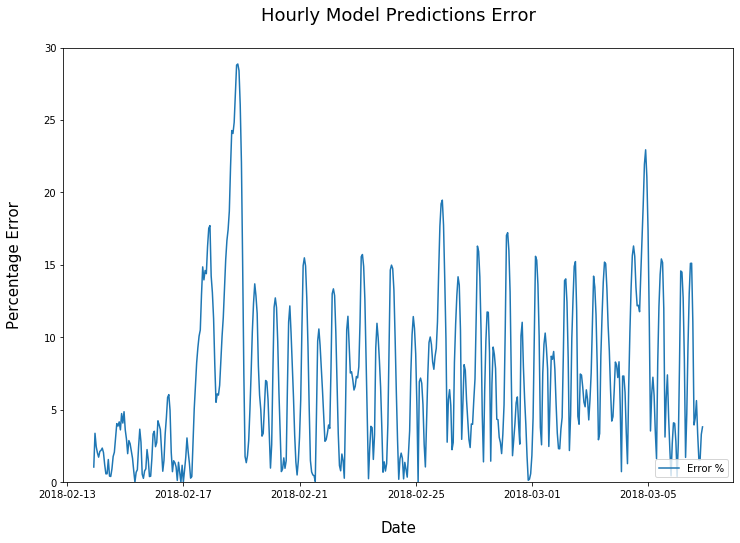

In [70]:
fig = plt.figure(figsize=[12, 8])
fig.patch.set_alpha(0.0)
fig.patch.set_facecolor(None)

plt.title('Hourly Model Predictions Error\n', fontsize=18)
plt.xlabel('\nDate', fontsize=15)
plt.ylabel('Percentage Error\n', fontsize=15)
plt.legend(loc='lower right')

ax = fig.add_subplot(1,1,1)
ax.patch.set_visible(False)
ax.set_alpha(0.0)

plt.plot(facecolor=('#000000'), alpha=0.0)

plt.plot(pred_times1, residuals2, label='Error %')
plt.ylim(0, 30)

plt.legend( loc='lower right')

plt.savefig('daily_pred_error_pct.png', Transparent=True)

In [71]:
print(res1.aic, res1.bic, res1.mse)

347500.7004899868 347581.1355932914 273425.5604430198


#### 5.2 SARIMAX With Exogeneous Data <a id='model-SARIMAX-wexog'></a>

In [72]:
# The trailing columns are city temperatures and state population
important_cities = ['Los Angeles', 'Fresno']
city_temps_pop = X_train[important_cities]

In [73]:
important_cities

['Los Angeles', 'Fresno']

In [74]:
# Define the seasonal model with exogenous data
seasonal_model2 = SARIMAX(X_train['demand'], exog=X_train[important_cities], \
    order=(5, 0, 1), seasonal_order=(1,0,0,24))
res2 = seasonal_model2.fit()

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [75]:
print(res2.summary())

                                      SARIMAX Results                                      
Dep. Variable:                              demand   No. Observations:                23006
Model:             SARIMAX(5, 0, 1)x(1, 0, [], 24)   Log Likelihood             -174614.092
Date:                             Sun, 22 Mar 2020   AIC                         349248.183
Time:                                     11:30:03   BIC                         349328.619
Sample:                                 07-01-2015   HQIC                        349274.322
                                      - 02-13-2018                                         
Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Los Angeles    21.3603      3.031      7.047      0.000      15.419      27.301
Fresno        -23.4986  

In [76]:
# Save the trained model
filename = 'SARIMAX_w_exog.sav'
pickle.dump(seasonal_model2, open(filename, 'wb'))

In [77]:
demand_hat2 = res2.fittedvalues

##### 5.2.1 SARIMAX With Exogeneous Data - Fit Plot Close <a id='plot-SARI_exog_fit_zoom'></a>

No handles with labels found to put in legend.
/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



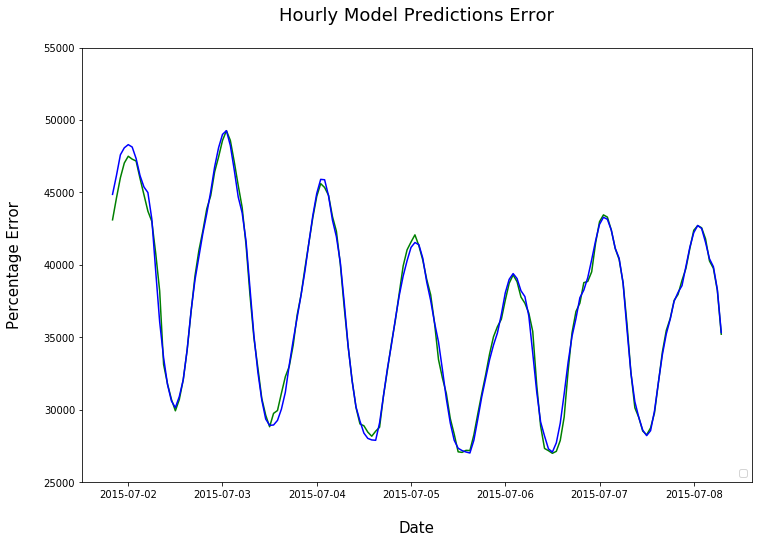

In [79]:
fig = plt.figure(figsize=[12, 8])
fig.patch.set_alpha(0.0)
fig.patch.set_facecolor(None)

plt.title('Hourly Model Predictions Error\n', fontsize=18)
plt.xlabel('\nDate', fontsize=15)
plt.ylabel('Percentage Error\n', fontsize=15)
plt.legend(loc='lower right')

ax = fig.add_subplot(1,1,1)
ax.patch.set_visible(False)
ax.set_alpha(0.0)

plt.plot(facecolor=('#000000'), alpha=0.0)


plt.ylim(25000, 55000)

plt.plot(demand_hat2[12:168], c='g')
plt.plot(X_train.index[12:168], X_train['demand'].values[12:168], c='b')
plt.savefig('hourly_pred_wexog.png', Transparent=True)

----
----

##### 5.2.2 SARIMAX With Exogeneous Data - Fit Plot 3 Month <a id='plot-SARI_exof_fit_wide'></a>

----

No handles with labels found to put in legend.
/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



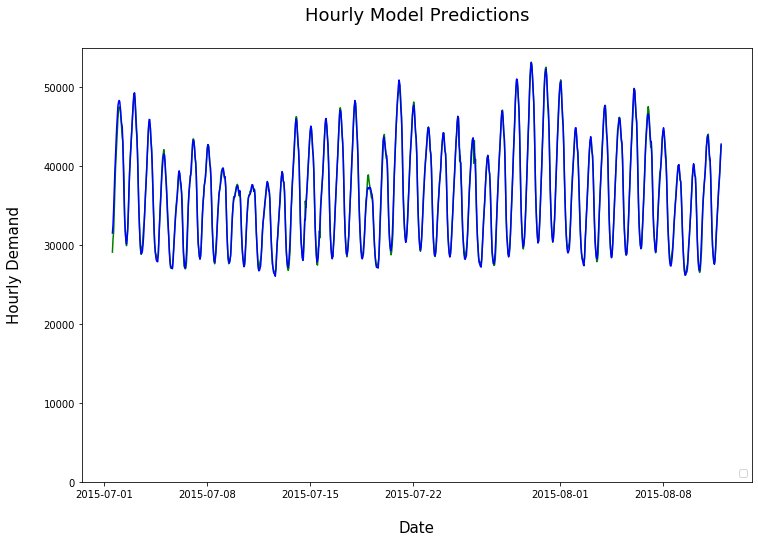

In [80]:
fig = plt.figure(figsize=[12, 8])
fig.patch.set_alpha(0.0)
fig.patch.set_facecolor(None)

plt.title('Hourly Model Predictions\n', fontsize=18)
plt.xlabel('\nDate', fontsize=15)
plt.ylabel('Hourly Demand\n', fontsize=15)
plt.legend(loc='lower right')

ax = fig.add_subplot(1,1,1)
ax.patch.set_visible(False)
ax.set_alpha(0.0)

plt.plot(facecolor=('#000000'), alpha=0.0)


plt.ylim(0, 55000)

plt.plot(demand_hat2[5:1000], c='g')
actual = X_train['demand'].values[12:1012]
plt.plot(X_train.index[5:1000], X_train['demand'].values[5:1000], c='b')

----
----
##### 5.2.3 SARIMAX With Exogeneous Data - Forecast  <a id='forecast-SARI_exog'></a>
----

In [81]:
predict_steps = 168*3
predict2 = res2.get_forecast(predict_steps, 
                exog=X_walk1[important_cities].values[:predict_steps, :])
pred_ci2 = predict2.conf_int(alpha=0.5)
pred_vals2 = predict2.predicted_mean

In [82]:
aic2 = res2.aic

No handles with labels found to put in legend.
/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



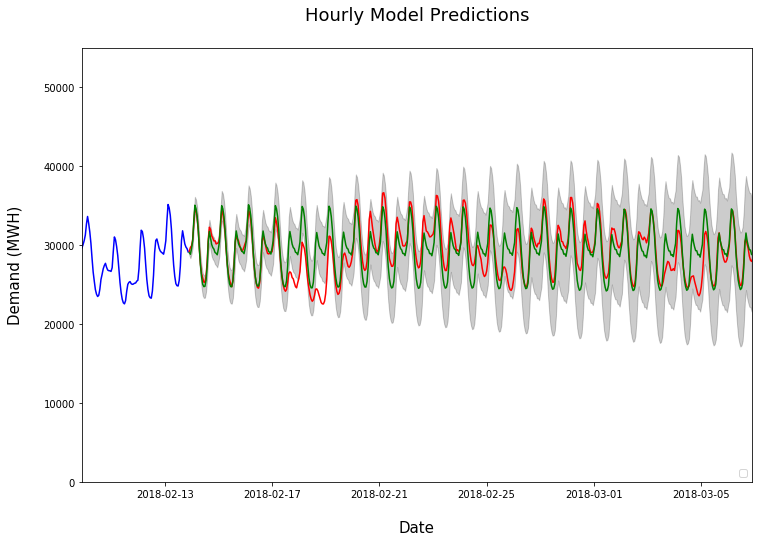

In [84]:
fig = plt.figure(figsize=[12, 8])

fig.patch.set_alpha(0.0)
fig.patch.set_facecolor(None)

plt.title('Hourly Model Predictions\n', fontsize=18)
plt.xlabel('\nDate', fontsize=15)
plt.ylabel('Demand (MWH)\n', fontsize=15)
plt.legend(loc='lower right')

ax = fig.add_subplot(1,1,1)
ax.patch.set_visible(False)
ax.set_alpha(0.0)

plt.plot(facecolor=('#000000'), alpha=0.0)

plt.ylim(0, 55000)
date_list = X_train.index

low_values = pred_ci2.iloc[:, 0].values
high_values = pred_ci2.iloc[:, 1].values
pred_times2 = pred_ci2.index

plt.xlim(min(date_list[int(len(date_list) - 24*4) :]), max(pred_times2))
#plt.ylim(min(low_values), max(high_values))

#plt.plot(demand_hat[:1000])
plt.plot(X_train.index, X_train['demand'].values, label='Training Demand', c='b')
plt.plot(X_walk1.index, X_walk1['demand'].values, c='r', label='Actual Demand')
plt.plot(pred_times2, pred_vals2.values, c='g', label='Predicted Demand')


plt.fill_between(pred_times2, low_values, high_values, color='k', alpha=0.2, label='Confidence Interval')
plt.savefig('hourly_forecast_wexog.png', Transparent=True)

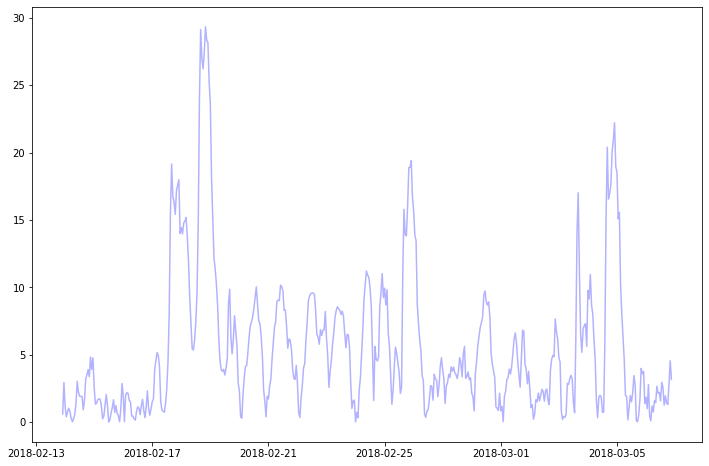

In [94]:
fig = plt.figure(figsize=[12, 8])
residuals2 = [abs(X_walk1['demand'].values[x] - pred_vals2.values[x]) / X_walk1['demand'].values[x] * 100 for x in range(len(pred_vals2))]
plt.plot(pred_times2, residuals2, c='b', alpha=0.3)


In [95]:
mape2 = np.mean(residuals2[:3*168])
print(mape2)

5.6072256080804435


----
----
#### 5.3 SARIMAX With Extended Exogeneous Data <a id='model-SARI-xexog'></a>
----

In [87]:
# Use all the dummies for the day of the week but don't use the DOW column
all_exog_dat = X_train.columns[1:-1]

In [88]:
# Define the seasonal model with exogenous data
seasonal_model3 = SARIMAX(X_train['demand'], exog=X_train[all_exog_dat], simple_differencing=True, \
    order=(3, 0, 3), seasonal_order=(3,0,0,24))

res3 = seasonal_model3.fit()
print(res3.summary())

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                      SARIMAX Results                                      
Dep. Variable:                              demand   No. Observations:                23006
Model:             SARIMAX(3, 0, 3)x(3, 0, [], 24)   Log Likelihood             -183112.193
Date:                             Sun, 22 Mar 2020   AIC                         366272.386
Time:                                     12:32:06   BIC                         366465.430
Sample:                                 07-01-2015   HQIC                        366335.118
                                      - 02-13-2018                                         
Covariance Type:                               opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Los Angeles     148.1927      7.260     20.411      0.000     133.963     162.423
San Diego       -6

In [89]:
# Save the trained model
filename = 'SARIMAX_w_xexog.sav'
pickle.dump(seasonal_model3, open(filename, 'wb'))

In [90]:
predict_steps = min([168*20, X_walk1.shape[0]])
predict3 = res3.get_forecast(predict_steps, 
                exog=X_walk1[all_exog_dat].values[:predict_steps, :])
pred_ci3 = predict3.conf_int(alpha=0.5)
pred_vals3 = predict3.predicted_mean

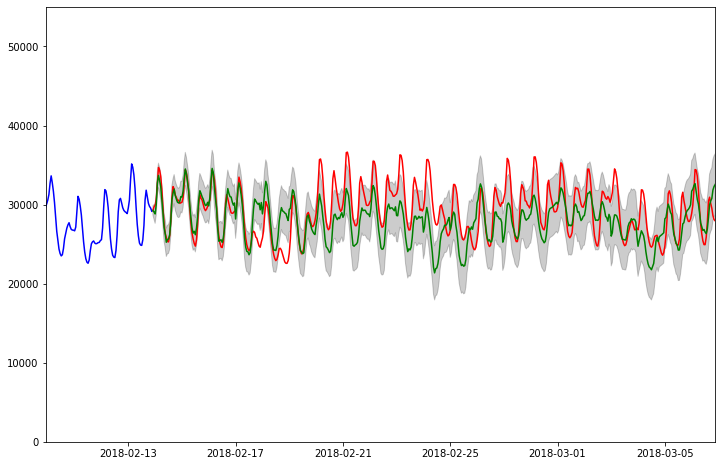

In [91]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 55000)
date_list = X_train.index

low_values = pred_ci3.iloc[:, 0].values
high_values = pred_ci3.iloc[:, 1].values
pred_times3 = pred_ci3.index

plt.xlim(min(date_list[int(len(date_list) - 24*4) :]), max(pred_times2))
#plt.ylim(min(low_values), max(high_values))

#plt.plot(demand_hat[:1000])
plt.plot(X_train.index[-3*168:], X_train['demand'].values[-3*168:], c='b')
plt.plot(X_walk1.index[:3*168], X_walk1['demand'].values[:3*168], c='r')
plt.plot(pred_times3, pred_vals3.values, c='g')


plt.fill_between(pred_times3, low_values, high_values, color='k', alpha=0.2)

(0, 50)

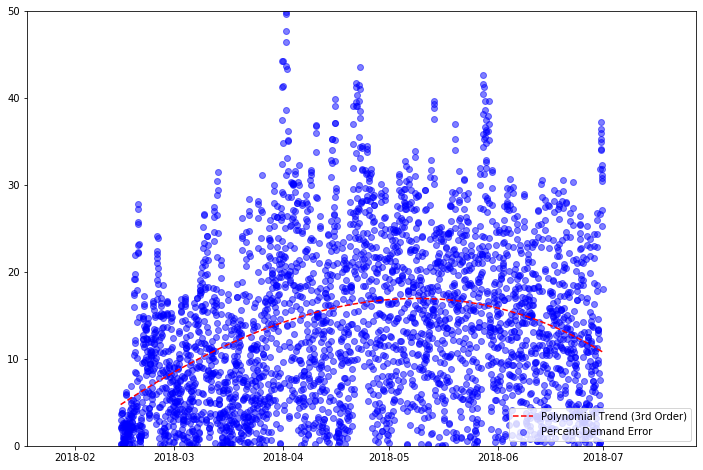

In [92]:
fig = plt.figure(figsize=[12, 8])
residuals3 = [abs(X_walk1['demand'].values[x] - pred_vals3.values[x])/ \
              X_walk1['demand'].values[x] * 100 for x in range(len(pred_vals3))]

timestamps = [int(x.timestamp()) for x in X_walk1.index]
z = np.polyfit(timestamps, residuals3, 3)
poly_trend = np.poly1d(z)
trend = [poly_trend(x) for x in timestamps]

plt.scatter(pred_times3, residuals3, c='b', alpha=0.5, label='Percent Demand Error')
plt.plot(X_walk1.index, trend,"r--", label='Polynomial Trend (3rd Order)')
plt.legend(loc='lower right')
plt.ylim(0, 50)

In [93]:
mape3 = np.mean(residuals3[:3*168])
print(mape3)

7.52253027565435


In [96]:
X_train = X_train.append(X_walk1)

In [99]:
# Define the seasonal model with exogenous data
seasonal_model3_2 = SARIMAX(X_train['demand'], exog=X_train[all_exog_dat], simple_differencing=True, \
    order=(3, 0, 3), seasonal_order=(3,0,0,24))

res3_2 = seasonal_model3_2.fit()
print(res3.summary())

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                      SARIMAX Results                                      
Dep. Variable:                              demand   No. Observations:                23006
Model:             SARIMAX(3, 0, 3)x(3, 0, [], 24)   Log Likelihood             -183112.193
Date:                             Sun, 22 Mar 2020   AIC                         366272.386
Time:                                     18:16:58   BIC                         366465.430
Sample:                                 07-01-2015   HQIC                        366335.118
                                      - 02-13-2018                                         
Covariance Type:                               opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Los Angeles     148.1927      7.260     20.411      0.000     133.963     162.423
San Diego       -6

In [90]:
predict_steps = min([168*20, X_walk2.shape[0]])
predict3_2 = res3_2.get_forecast(predict_steps, 
                exog=X_walk2[all_exog_dat].values[:predict_steps, :])
pred_ci3_2 = predict3_2.conf_int(alpha=0.5)
pred_vals3_2 = predict3_2.predicted_mean

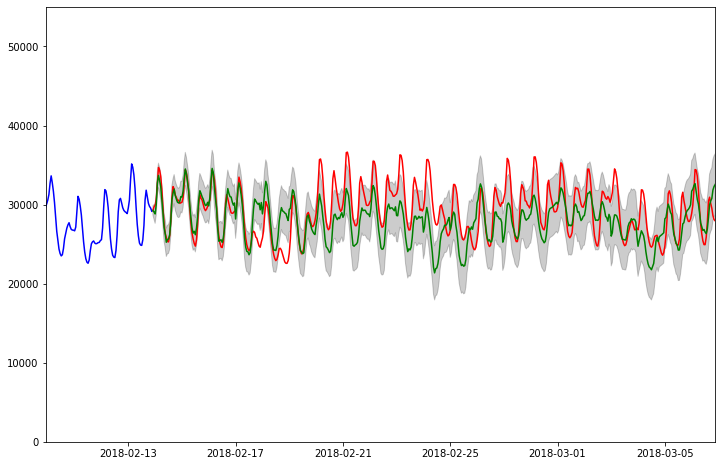

In [91]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 55000)
date_list = X_train.index

low_values = pred_ci3_2.iloc[:, 0].values
high_values = pred_ci3_2.iloc[:, 1].values
pred_times3 = pred_ci3_2.index

plt.xlim(min(date_list[int(len(date_list) - 24*4) :]), max(pred_times2))
#plt.ylim(min(low_values), max(high_values))

#plt.plot(demand_hat[:1000])
plt.plot(X_train.index[-3*168:], X_train['demand'].values[-3*168:], c='b')
plt.plot(X_walk2.index[:3*168], X_walk2['demand'].values[:3*168], c='r')
plt.plot(pred_times3_2, pred_vals3_2.values, c='g')


plt.fill_between(pred_times3_2, low_values, high_values, color='k', alpha=0.2)

(0, 50)

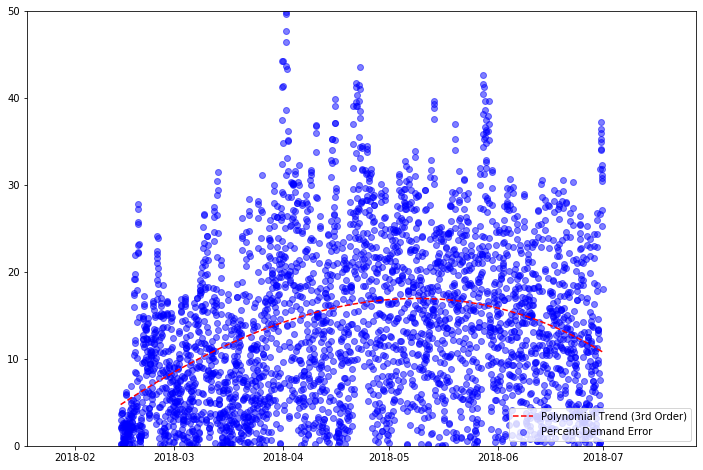

In [92]:
fig = plt.figure(figsize=[12, 8])
residuals3_2 = [abs(X_walk2['demand'].values[x] - pred_vals3_2.values[x])/ \
              X_walk2['demand'].values[x] * 100 for x in range(len(pred_vals3_2))]

timestamps = [int(x.timestamp()) for x in X_walk1.index]
z = np.polyfit(timestamps, residuals3_2, 3)
poly_trend = np.poly1d(z)
trend = [poly_trend(x) for x in timestamps]

plt.scatter(pred_times3_2, residuals3_2, c='b', alpha=0.5, label='Percent Demand Error')
plt.plot(X_walk2.index, trend,"r--", label='Polynomial Trend (3rd Order)')
plt.legend(loc='lower right')
plt.ylim(0, 50)

In [93]:
mape3_2 = np.mean(residuals3_2[:3*168])
print(mape3_2)

7.52253027565435


In [100]:
X_train = X_train.append(X_walk2)

In [101]:
# Define the seasonal model with exogenous data
seasonal_model3_3 = SARIMAX(X_train['demand'], exog=X_train[all_exog_dat], simple_differencing=True, \
    order=(3, 0, 3), seasonal_order=(3,0,0,24))

res3_3 = seasonal_model3_3.fit()

In [115]:
print(res3_3.summary())

                                      SARIMAX Results                                      
Dep. Variable:                              demand   No. Observations:                29578
Model:             SARIMAX(3, 0, 3)x(3, 0, [], 24)   Log Likelihood             -237104.058
Date:                             Sun, 22 Mar 2020   AIC                         474256.116
Time:                                     20:33:33   BIC                         474455.191
Sample:                                          0   HQIC                        474320.035
                                           - 29578                                         
Covariance Type:                               opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Los Angeles     190.1467      6.010     31.641      0.000     178.368     201.925
San Diego       -8

In [120]:
X_train.index = pd.to_datetime(X_train.index)
X_walk3.index = pd.to_datetime(X_walk3.index)
X_train.tail()

,demand,Los Angeles,San Diego,San Jose,San Francisco,Sacramento,Fresno,CA_pop,Mon,Tue,Wed,Thur,Fri,Sat,Sun,DOW
2018-11-14 18:00:00+00:00,30795,74.49,71.23,58.28,54.17,44.98,51.63,14084824.0,0,0,1,0,0,0,0,2
2018-11-14 19:00:00+00:00,30348,74.94,74.40,61.30,56.68,48.81,58.44,14084824.0,0,0,1,0,0,0,0,2
2018-11-14 20:00:00+00:00,30260,76.80,75.55,64.58,59.53,53.14,60.57,14084824.0,0,0,1,0,0,0,0,2
2018-11-14 21:00:00+00:00,30484,78.47,76.16,67.88,62.17,55.58,63.72,14084824.0,0,0,1,0,0,0,0,2
2018-11-14 22:00:00+00:00,31037,79.05,74.98,68.89,63.17,58.04,65.59,14084824.0,0,0,1,0,0,0,0,2


In [121]:
type(X_train.index[0])

pandas._libs.tslibs.timestamps.Timestamp

In [122]:
predict_steps = min([168*20, X_walk3.shape[0]])
predict3_3 = res3_3.get_forecast(predict_steps, 
                exog=X_walk3[all_exog_dat].values[:predict_steps, :])
#pred_ci3_3 = predict3_3.conf_int(alpha=0.5)
#pred_vals3_3 = predict3_3.predicted_mean

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



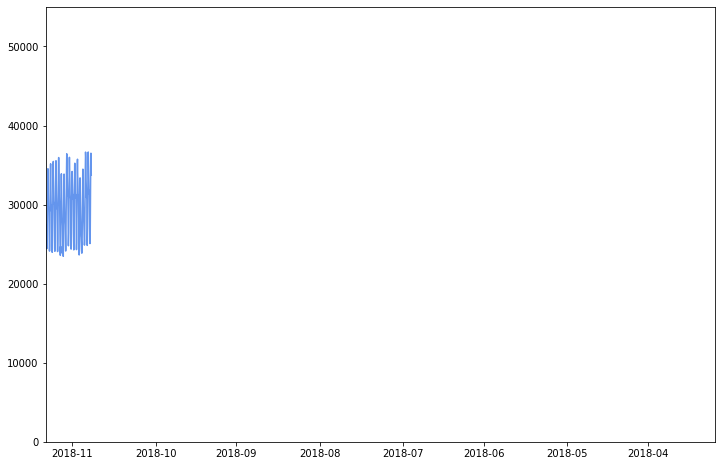

In [123]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 55000)
date_list = X_train.index

low_values = pred_ci3_3.iloc[:, 0].values
high_values = pred_ci3_3.iloc[:, 1].values
pred_times3_3 = pred_ci3_3.index

plt.xlim(min(date_list[int(len(date_list) - 24*4) :]), max(pred_times2))
#plt.ylim(min(low_values), max(high_values))

#plt.plot(demand_hat[:1000])
plt.plot(X_train.index[-3*168:], X_train['demand'].values[-3*168:], c='cornflowerblue')
plt.plot(X_walk3.index[:3*168], X_walk3['demand'].values[:3*168], c='b')
plt.plot(pred_times3_3, pred_vals3_3.values, c='g')


plt.fill_between(pred_times3_3, low_values, high_values, color='k', alpha=0.2)

(0, 50)

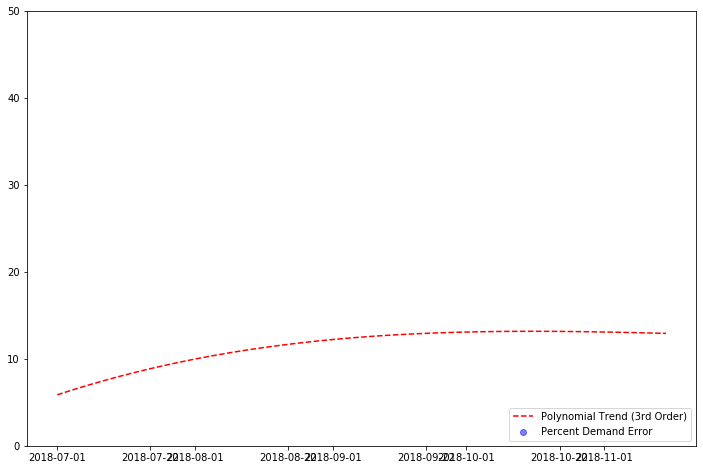

In [125]:
fig = plt.figure(figsize=[12, 8])
residuals3_3 = [abs(X_walk3['demand'].values[x] - pred_vals3_3.values[x])/ \
              X_walk3['demand'].values[x] * 100 for x in range(len(pred_vals3_3))]

timestamps = [int(x.timestamp()) for x in X_walk1.index]
z = np.polyfit(timestamps, residuals3_3, 3)
poly_trend = np.poly1d(z)
trend = [poly_trend(x) for x in timestamps]

plt.scatter(pred_times3_3, residuals3_3, c='b', alpha=0.5, label='Percent Demand Error')
plt.plot(X_walk2.index, trend,"r--", label='Polynomial Trend (3rd Order)')
plt.legend(loc='lower right')
plt.ylim(0, 50)

In [128]:
mape3_3 = np.mean(residuals3_3[:3*168])
print(mape3_3)

7.515932920006532
